# Data Reconstruction

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/IBM_AI_Engineering/portfolio-17.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Reconstruct an image using a Restricted Boltzmann Machine.

[Restricted Boltzmann Machine (RBM)](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) is a shallow neural network that learn to reconstruct data by themselves in an unsupervised fashion. An RBM is a basic form of autoencoder. It can automatically extract meaningful features from a given input.

RBM is a 2 layer neural network. Simply, RBM takes the inputs and translates those into a set of binary values that represents them in the hidden layer. Then, these numbers can be translated back to reconstruct the inputs. Through several forward and backward passes, the RBM will be trained, and a trained RBM can reveal which features are the most important ones when detecting patterns. 

RBM is useful for collaborative filtering, dimensionality reduction, classification, regression, feature learning, topic modeling and even deep belief networks. 

## Import libraries

In [1]:
import time
from PIL import Image
import tensorflow as tf
from keras import datasets, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2025-03-07 01:28:43.421406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741332523.438300  408106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741332523.445033  408106 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 01:28:43.462228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the dataset

We will be using the MNIST dataset to implement the usage of RBMs.

In [2]:
(X_train, y_train), _ = datasets.mnist.load_data()

print("X_train shape:", X_train.shape)

X_train shape: (60000, 28, 28)


## Visualize the dataset

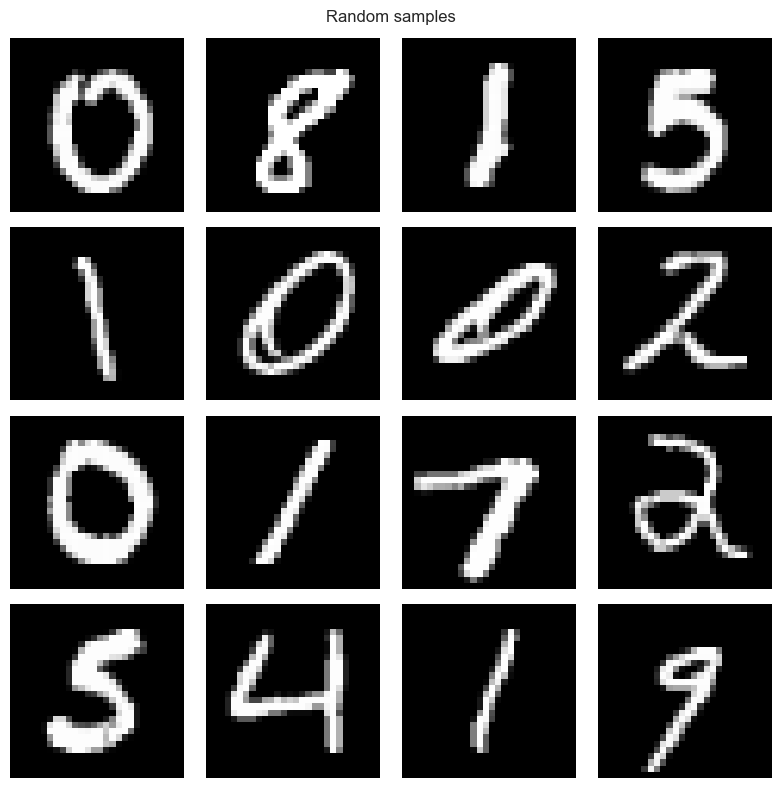

In [3]:
indexes = np.random.choice(range(0, X_train.shape[0]), size=16, replace=False)
samples = X_train[indexes]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for ax, sample in zip(axs.flatten(), samples):
    ax.imshow(sample, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Build a restricted Boltzmann machine

An RBM has two layers. The first layer of the RBM is called the visible (or input layer). The second layer is the hidden layer, which has neurons in our case. Each hidden node takes on values of either 0 or 1, with a probability that is a logistic function of the inputs it receives from the other visible units. 

In [4]:
hiddenUnits = 50
visibleUnits = X_train[0].size

# Define the bias of the visible and hidden layers
vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) # Size: Number of pixels
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) # Size: Number of features we're going to learn

# Define weights among the input layer and hidden layer nodes. In the weight matrix, the number of rows are equal to the input nodes, 
# and the number of columns are equal to the output nodes. 
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

# Define the visible layer
v0 = tf.zeros([visibleUnits], tf.float32)

I0000 00:00:1741332268.939222  403267 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1526 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
# Phase 1: Input Processing
# Defining a function to return only the generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb) # Probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) # sample_h_given_X

    return h0_state

# Define hidden layer
h0 = hidden_layer(v0, W, hb)
print("Hidden state shape:", h0.shape)

Hidden state shape: (1, 50)


In [6]:
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) # sample_v_given_h
    
    return v1_state[0]

# Define reconstruction part
v1 = reconstructed_output(h0, W, vb)
print("v0 state shape:", v0.shape)
print("v1 state shape:", v1.shape)

v0 state shape: (784,)
v1 state shape: (784,)


In each epoch, we compute the "error" as a sum of the squared difference between step `1` and step `n`. The error shows the difference between the data and its reconstruction.

In [7]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

## Train the model

In [8]:
# Define parameters
epochs = 1
batchsize = 200
errors = []
weights = []
K = 1 # A good performance can be achieved with K = 1, so that we just take one set of sampling steps per image
alpha = 0.01 # Learning rate

# Creating datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batchsize)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}:")
    batch_number = 0
    number_of_batches = int(len(X_train) / batchsize)
    batches_to_show = [0] + [i for i in range(int(number_of_batches/10)-1, number_of_batches, int(number_of_batches/10))]

    for batch_x, batch_y in train_ds:
        start_time = time.time()
        batch_x = layers.Rescaling(scale=1./255)(batch_x)
        batch_x = layers.Flatten(dtype='float32')(batch_x)

        for i_sample in range(batchsize):            
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == batchsize - 1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)

                if batch_number in batches_to_show:
                    print(f"\tBatch {batch_number + 1}/{number_of_batches}:")
                    print(f"\t\telapsed time: {(time.time() - start_time):.3f}s - reconstruction error: {err:.4f}")
                
        batch_number += 1

Epoch 1/1:
	Batch 1/300:
		elapsed time: 0.871s - reconstruction error: 0.1674
	Batch 30/300:
		elapsed time: 0.639s - reconstruction error: 0.0880
	Batch 60/300:
		elapsed time: 0.631s - reconstruction error: 0.0906
	Batch 90/300:
		elapsed time: 0.668s - reconstruction error: 0.0834
	Batch 120/300:
		elapsed time: 0.711s - reconstruction error: 0.0752
	Batch 150/300:
		elapsed time: 0.705s - reconstruction error: 0.0359
	Batch 180/300:
		elapsed time: 0.658s - reconstruction error: 0.0761
	Batch 210/300:
		elapsed time: 0.690s - reconstruction error: 0.1082
	Batch 240/300:
		elapsed time: 0.674s - reconstruction error: 0.1084
	Batch 270/300:
		elapsed time: 0.646s - reconstruction error: 0.0866
	Batch 300/300:
		elapsed time: 0.646s - reconstruction error: 0.0831


2025-03-07 01:27:50.604299: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


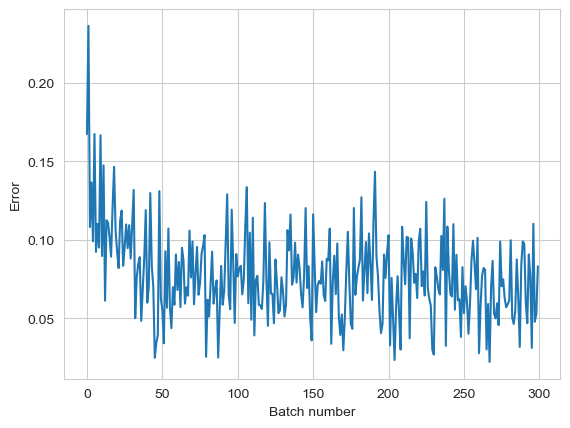

In [9]:
plt.figure()
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Batch number')
plt.show()

## Evaluate the model

In [10]:
""" Utility functions that help in
processing the outputs into a more understandable way.

``tile_raster_images`` helps in generating a easy to grasp
image from a set of samples or weights.
"""

def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)

    return ndar

def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True, output_pixel_vals=True):
    """
    Transform an array with one flattened image per row, into an array in
    which images are reshaped and layed out like tiles on a floor.

    This function is useful for visualizing datasets whose rows are images,
    and also columns of matrices for transforming those rows
    (such as the first layer of a neural net).

    :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
    be 2-D ndarrays or None;
    :param X: a 2-D array in which every row is a flattened image.

    :type img_shape: tuple; (height, width)
    :param img_shape: the original shape of each image

    :type tile_shape: tuple; (rows, cols)
    :param tile_shape: the number of images to tile (rows, cols)

    :param output_pixel_vals: if output should be pixel values (i.e. int8
    values) or floats

    :param scale_rows_to_unit_interval: if the values need to be scaled before
    being plotted to [0,1] or not

    :returns: array suitable for viewing as an image.
    (See:`Image.fromarray`.)
    :rtype: a 2-d array with same dtype as X.
    """

    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2

    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape    = [0,0]
    # out_shape[0] = (img_shape[0]+tile_spacing[0])*tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1]+tile_spacing[1])*tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [(ishp + tsp) * tshp - tsp for ishp, tshp, tsp in zip(img_shape, tile_shape, tile_spacing)]

    if isinstance(X, tuple):
        assert len(X) == 4

        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype='uint8')
        else:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype=X.dtype)

        # Colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # If channel is None, fill it with zeros of the correct dtype
                dt = out_array.dtype

                if output_pixel_vals:
                    dt = 'uint8'

                out_array[:, :, i] = np.zeros(out_shape, dtype=dt) + channel_defaults[i]
            else:
                # Use a recurrent call to compute the channel and store it in the output
                out_array[:, :, i] = tile_raster_images(X[i], img_shape, tile_shape, tile_spacing,
                                                        scale_rows_to_unit_interval, output_pixel_vals)
                
        return out_array
    else:
        # If we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # Generate a matrix to store the output
        dt = X.dtype

        if output_pixel_vals:
            dt = 'uint8'

        out_array = np.zeros(out_shape, dtype=dt)

        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    this_x = X[tile_row * tile_shape[1] + tile_col]

                    if scale_rows_to_unit_interval:
                        # If we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval` function
                        this_img = scale_to_unit_interval(this_x.reshape(img_shape))
                    else:
                        this_img = this_x.reshape(img_shape)

                    # Add the slice to the corresponding position in the output array
                    c = 1

                    if output_pixel_vals:
                        c = 255

                    out_array[tile_row * (H + Hs): tile_row * (H + Hs) + H,
                              tile_col * (W + Ws): tile_col * (W + Ws) + W] = this_img * c
                    
        return out_array

We have a destructed image of figure 3. Let's see if our trained network can fix it.

In [11]:
!wget -nc --progress=bar:force:noscroll https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg -O /tmp/destructed3.jpg

File '/tmp/destructed3.jpg' already there; not retrieving.


In [12]:
# Convert the image to a 1d numpy array
destructed_image = Image.open("/tmp/destructed3.jpg").convert('L').resize((28, 28))
sample_case = np.array(destructed_image).ravel().reshape((1, -1)) / 255
sample_case = tf.cast(sample_case, dtype=tf.float32)

# Feed the sample case into the network and reconstruct the input
hh0 = tf.nn.sigmoid(tf.matmul([sample_case], W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)

# Generate reconstructed image
reconstructed_image = Image.fromarray(tile_raster_images(X=vv1.numpy(), img_shape=(28, 28), tile_shape=(1, 1), tile_spacing=(1, 1)))

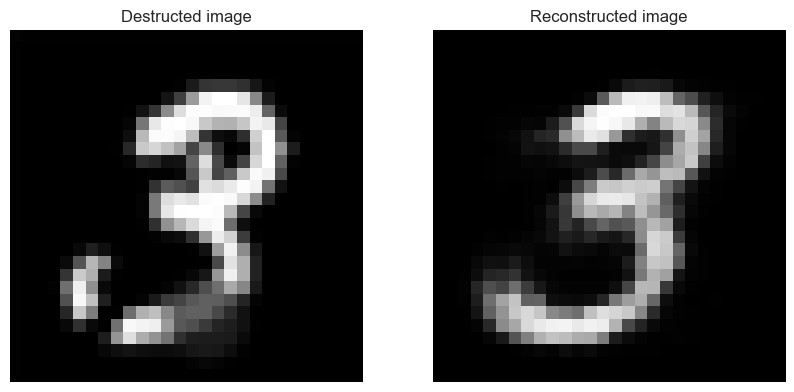

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(destructed_image, cmap="gray")
axs[0].set_title("Destructed image")
axs[0].axis("off")

axs[1].imshow(reconstructed_image, cmap="gray")
axs[1].set_title("Reconstructed image")
axs[1].axis("off")

plt.show()